In [ ]:
# Importing relevant packages and libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from nltk.stem import WordNetLemmatizer


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the dataset and printing first 5 rows
df = pd.read_csv('/content/drive/MyDrive/BT5153/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Returning the number of observations and features in the dataset
df.shape

(7613, 5)

In [ ]:
# Returning the information on the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## **Data Preprocessing**

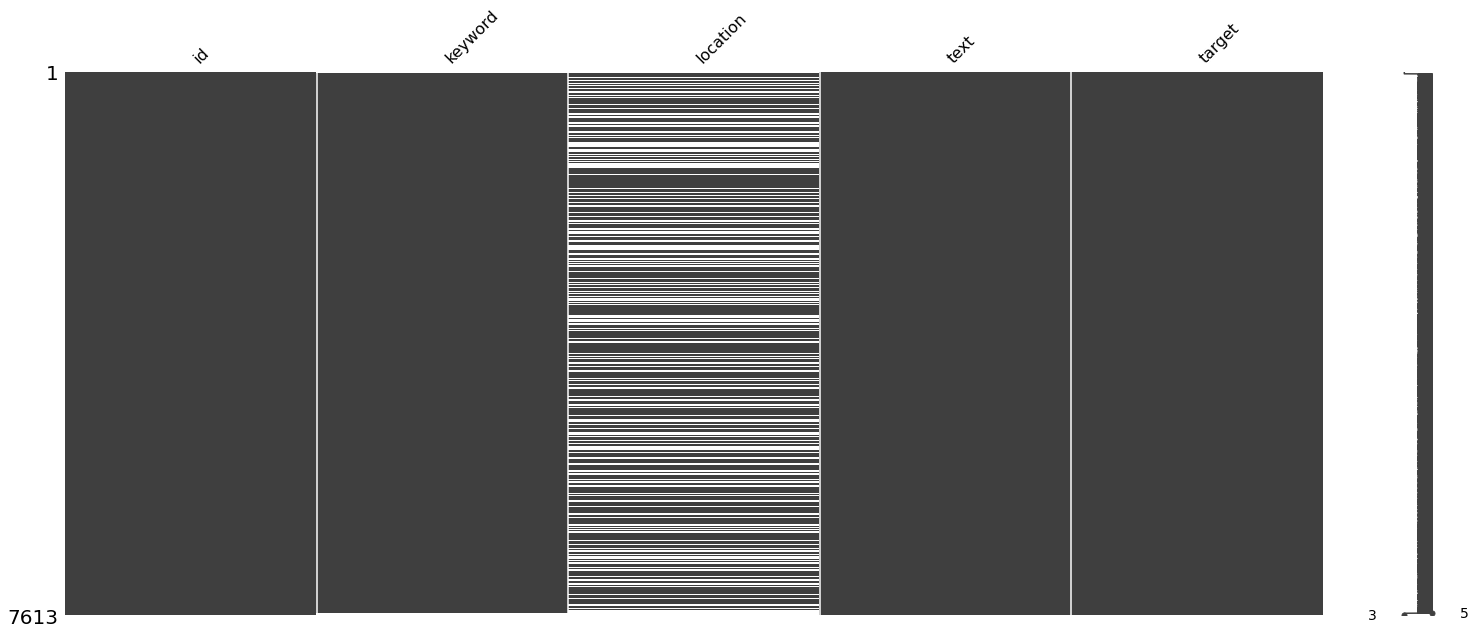

In [ ]:
# Checking missing values
msno.matrix(df)
plt.show()

We observed that there are many missing values in the location feature.

In [ ]:
# Checking class imbalance
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Defining functions for stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def pre_process(text):
    #remove url
    text = re.sub(r'http\S+', '', text)
    #remove special characters
    text = re.sub('\W', ' ', text)
    #remove digits
    text = re.sub(r'\d+', '', text)
    #remove underline
    text = re.sub(r'_',' ', text)  
    #remove white spaces
    text = re.sub(r'\s+',' ', text)
    #to lower
    text = text.lower()
    #correct typos
    # text = str(TextBlob(text).correct())

    #remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stop_words)])
    #lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
        # remove single letters
    text = ' '.join(i for i in text.split() if not (i.isalpha() and len(i)==1))
    return text

In [ ]:
df['preprocessed'] = df['text'].apply(lambda x: pre_process(x))


In [ ]:
df

,id,keyword,location,text,target,preprocessed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse nearby...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest control wild fire cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc km volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating bike collided car little ...


In [ ]:
# Defining X and y variable
X = df.preprocessed
y = df.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf_train = vectorizer.fit_transform(X_train)
X_tfidf_test = vectorizer.transform(X_test)

In [ ]:
features = vectorizer.get_feature_names()

In [ ]:
weights = np.asarray(X_tfidf_train.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': features, 'weight': weights})
weights_df_top20 = weights_df.sort_values(by='weight', ascending=False).head(20)

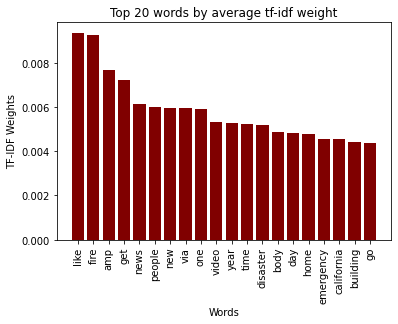

In [ ]:
plt.bar(weights_df_top20.term, weights_df_top20.weight, color ='maroon',width = 0.8)
plt.title('Top 20 words by average tf-idf weight')
plt.xlabel('Words')
plt.xticks(rotation=90)
plt.ylabel('TF-IDF Weights')
plt.show()

##**Classic Machine Learning Models**

#####**Model 1: Random Forest Classifier**

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_tfidf_train,y_train)
y_pred = model.predict(X_tfidf_test)

In [ ]:
print('Accuracy: ', accuracy_score(y_pred,y_test))
print('AUC Score: ', roc_auc_score(y_pred,y_test))
print('F1 Score: ',f1_score(y_pred,y_test))

Accuracy:  0.7872899159663865
AUC Score:  0.7863673008328996
F1 Score:  0.7361563517915309


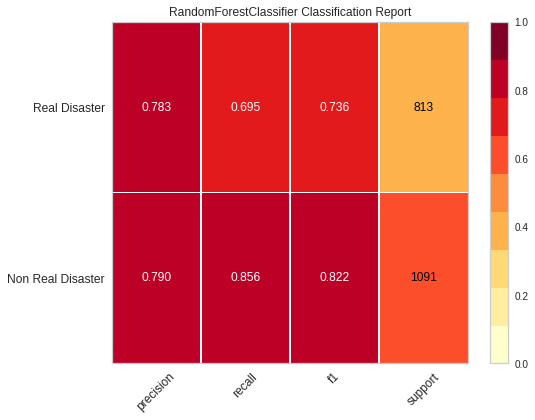

In [ ]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import classification_report

classes = ['Non Real Disaster', 'Real Disaster']

viz = classification_report(model,X_tfidf_train, y_train, X_tfidf_test, y_test, support=True, classes=classes,fig=plt.figure(figsize=(8,6)))
viz.show();

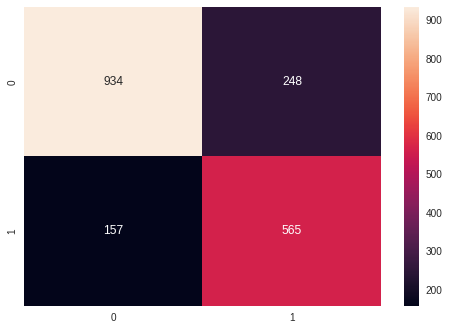

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#####**Model 2: Logistic Regression**

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_tfidf_train,y_train)
y_pred = model.predict(X_tfidf_test)

In [ ]:
print('Accuracy: ', accuracy_score(y_pred,y_test))
print('AUC Score: ', roc_auc_score(y_pred,y_test))
print('F1 Score: ',f1_score(y_pred,y_test))

Accuracy:  0.8072478991596639
AUC Score:  0.8113723516441377
F1 Score:  0.7548430193720775


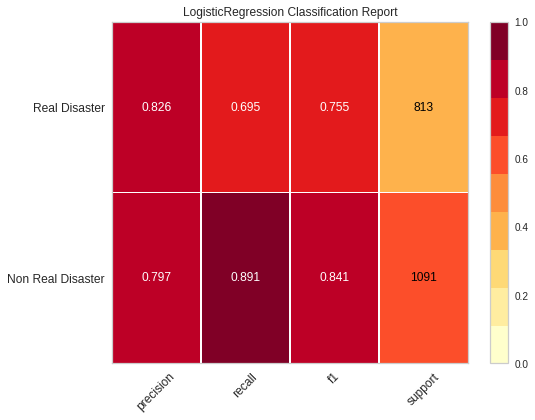

In [ ]:
viz = classification_report(model,X_tfidf_train, y_train, X_tfidf_test, y_test, support=True, classes=classes,fig=plt.figure(figsize=(8,6)))
viz.show();

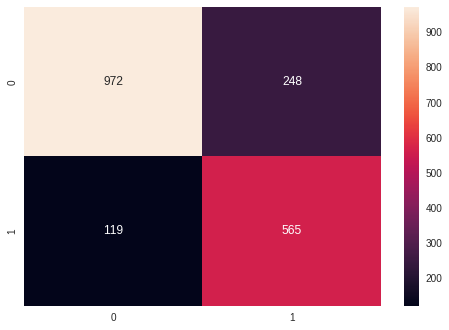

In [ ]:
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#####**Model 3: Multinomial Naive Bayes**

In [ ]:
model = MultinomialNB()
model.fit(X_tfidf_train,y_train)
y_pred = model.predict(X_tfidf_test)

In [ ]:
print('Accuracy: ', accuracy_score(y_pred,y_test))
print('AUC Score: ', roc_auc_score(y_pred,y_test))
print('F1 Score: ',f1_score(y_pred,y_test))

Accuracy:  0.7977941176470589
AUC Score:  0.8020136653624501
F1 Score:  0.7414372061786434


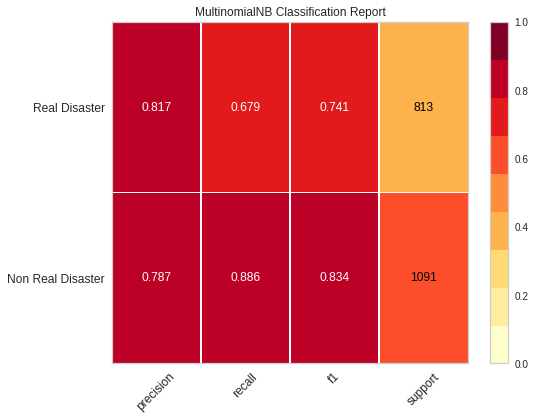

In [ ]:
viz = classification_report(model,X_tfidf_train, y_train, X_tfidf_test, y_test, support=True, classes=classes,fig=plt.figure(figsize=(8,6)))
viz.show();

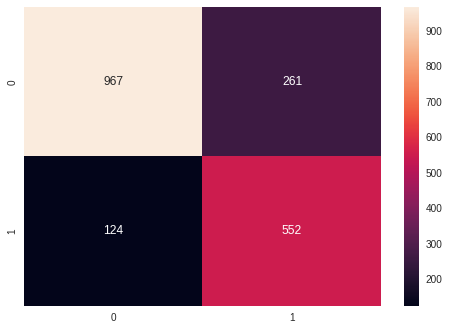

In [ ]:
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#####**Model 4: LightGBM Classifier**

In [ ]:
model = LGBMClassifier(random_state=42)
model.fit(X_tfidf_train, y_train)
y_pred = model.predict(X_tfidf_test)

In [ ]:
print('Accuracy: ', accuracy_score(y_pred,y_test))
print('AUC Score: ', roc_auc_score(y_pred,y_test))
print('F1 Score: ',f1_score(y_pred,y_test))

Accuracy:  0.7678571428571429
AUC Score:  0.7670303196838102
F1 Score:  0.7084432717678102


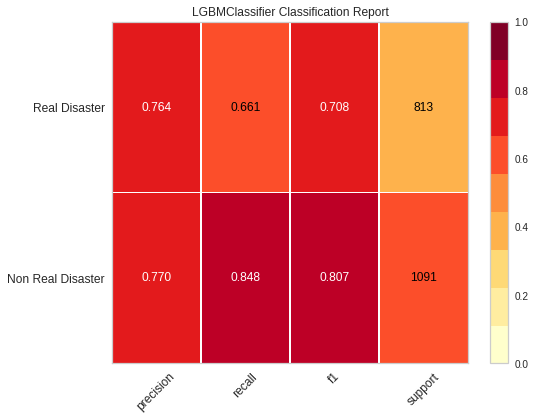

In [ ]:
viz = classification_report(model,X_tfidf_train, y_train, X_tfidf_test, y_test, support=True, classes=classes,fig=plt.figure(figsize=(8,6)))
viz.show();

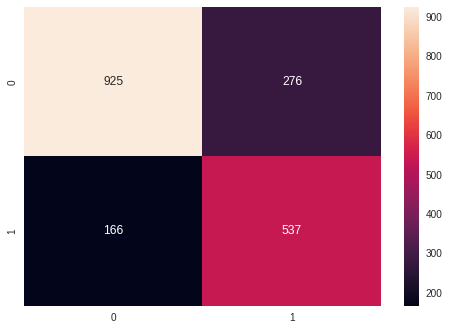

In [ ]:
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
# Hyperparameter tuning LightGBM parameters
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
random_grid ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
clf = LGBMClassifier(max_depth=-1, random_state=42, silent=True, n_jobs=-1, n_estimators=5000)
lgbm_random = RandomizedSearchCV(
              estimator=clf, param_distributions=random_grid, 
              n_iter=100,
              cv=3,
              refit=True,
              random_state=42,
              verbose=True)
lgbm_random.fit(X_tfidf_train,y_train)
y_pred_rscv = lgbm_random.predict(X_tfidf_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
print('Accuracy: ', accuracy_score(y_pred_rscv,y_test))
print('AUC Score: ', roc_auc_score(y_pred_rscv,y_test))
print('F1 Score: ',f1_score(y_pred_rscv,y_test))

Accuracy:  0.6323529411764706
AUC Score:  0.6614083264405844
F1 Score:  0.358974358974359


#####**Model 5: SVC**

In [ ]:
model = SVC(random_state=42)
model.fit(X_tfidf_train, y_train)
y_pred = model.predict(X_tfidf_test)

In [ ]:
print('Accuracy: ', accuracy_score(y_pred,y_test))
print('AUC Score: ', roc_auc_score(y_pred,y_test))
print('F1 Score: ',f1_score(y_pred,y_test))

Accuracy:  0.8088235294117647
AUC Score:  0.8187039588171524
F1 Score:  0.7499999999999999


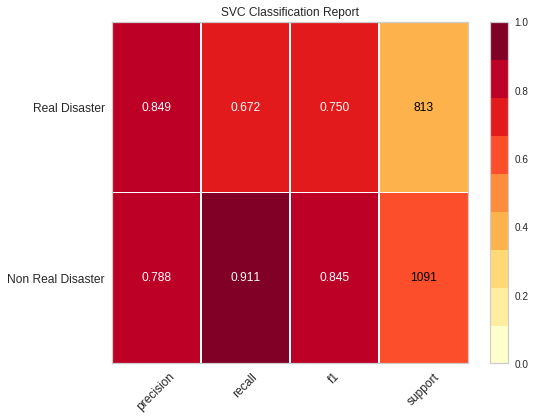

In [ ]:
viz = classification_report(model,X_tfidf_train, y_train, X_tfidf_test, y_test, support=True, classes=classes,fig=plt.figure(figsize=(8,6)))
viz.show();

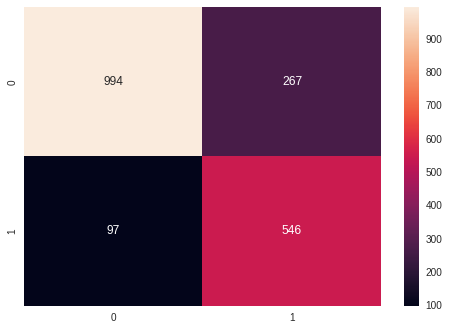

In [ ]:
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()